In [2]:
#scrape data from wiki page
from bs4 import BeautifulSoup
import requests
import pandas as pd

df = pd.DataFrame(columns=['Postcode', 'Borough', 'Neighbourhood'])

with open('wikipage.htm') as html_file:
    soup = BeautifulSoup(html_file,'lxml')

i=0    
for code in soup.find('div',class_='mw-parser-output').table.tbody.find_all('tr'):
    list0=list()
    for element in code.find_all('td'):
        list0.append(element.text.strip())
    if list0==list():continue
    df.loc[i]=list0
    i=i+1

pd.options.mode.chained_assignment = None

#get rid of the ones with no assigned borough
df_bo=df[df['Borough']!='Not assigned']


#deal with no neighbourhood
index=(df_bo['Neighbourhood']=='Not assigned')
index
df_bo.loc[index,'Neighbourhood']=df_bo.loc[index,'Borough']




#combine the ones with same postcode
df_nei=df_bo.groupby(['Postcode','Borough']).Neighbourhood.apply(lambda x : ",".join(x)).to_frame()

#final data
df_canada=df_nei.reset_index()

data = pd.read_csv("Geospatial_Coordinates.csv") 
data.rename(columns={'Postal Code':'Postcode'}, inplace=True)

df_merge =pd.merge(df_canada,data,how='left',on='Postcode')
df_merge.head()


,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [3]:
df_merge['Borough'].unique()

array(['Scarborough', 'North York', 'East York', 'East Toronto',
       'Central Toronto', 'Downtown Toronto', 'York', 'West Toronto',
       "Queen's Park", 'Mississauga', 'Etobicoke'], dtype=object)

In [4]:
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 


!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library




Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



In [5]:
#foursquare api
import random

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#Define Foursquare Credentials and Version
CLIENT_ID = '2USAT4JF3HVHMVFO4IRPNZHPUHNVYEM2BC3LY1OUHMZYNZPU' # your Foursquare ID
CLIENT_SECRET = 'VTKBIKZJDYXLRZZEYGWT54KNDB1K3MUBN5EKTAOQ5LEV0OWJ' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30

In [6]:
address = 'Toronto,Canada'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))
LIMIT = 100
radius = 500

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
# get nearby venues
#df_toronto=df_merge[df_merge["Borough"].isin(
#    ["East Toronto","Central Toronto","Downtown Toronto","West Toronto"])]
df_toronto=df_merge
toronto_venues = getNearbyVenues(names=df_toronto['Neighbourhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude'])

Rouge,Malvern
Highland Creek,Rouge Hill,Port Union
Guildwood,Morningside,West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park,Ionview,Kennedy Park
Clairlea,Golden Mile,Oakridge
Cliffcrest,Cliffside,Scarborough Village West
Birch Cliff,Cliffside West
Dorset Park,Scarborough Town Centre,Wexford Heights
Maryvale,Wexford
Agincourt
Clarks Corners,Sullivan,Tam O'Shanter
Agincourt North,L'Amoreaux East,Milliken,Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview,Henry Farm,Oriole
Bayview Village
Silver Hills,York Mills
Newtonbrook,Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park,Don Mills South
Bathurst Manor,Downsview North,Wilson Heights
Northwood Park,York University
CFB Toronto,Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens,Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West,Riverdale
The Beaches West,Indi

In [10]:
print(toronto_venues.shape)

(2234, 7)


In [11]:
toronto_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge,Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge,Malvern",43.806686,-79.194353,Interprovincial Group,43.805630,-79.200378,Print Shop
2,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
3,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
4,"Guildwood,Morningside,West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


In [12]:
toronto_venues.groupby("Neighbourhood").count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
"Adelaide,King,Richmond",100,100,100,100,100,100
Agincourt,4,4,4,4,4,4
"Agincourt North,L'Amoreaux East,Milliken,Steeles East",2,2,2,2,2,2
"Albion Gardens,Beaumond Heights,Humbergate,Jamestown,Mount Olive,Silverstone,South Steeles,Thistletown",7,7,7,7,7,7
"Alderwood,Long Branch",10,10,10,10,10,10
"Bathurst Manor,Downsview North,Wilson Heights",21,21,21,21,21,21
Bayview Village,4,4,4,4,4,4
"Bedford Park,Lawrence Manor East",23,23,23,23,23,23
Berczy Park,59,59,59,59,59,59


In [13]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 274 uniques categories.


In [14]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

#toronto_onehot["Neighborhood"]

# add neighborhood column back to dataframe
toronto_onehot = pd.concat([toronto_venues['Neighbourhood'], toronto_onehot], axis=1)

toronto_onehot

,Neighbourhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Rouge,Malvern",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Rouge,Malvern",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Highland Creek,Rouge Hill,Port Union",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Guildwood,Morningside,West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Guildwood,Morningside,West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,"Guildwood,Morningside,West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,"Guildwood,Morningside,West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,"Guildwood,Morningside,West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,"Guildwood,Morningside,West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,"Guildwood,Morningside,West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped

,Neighbourhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide,King,Richmond",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,...,0.020000,0.00,0.000000,0.000000,0.00,0.010000,0.000000,0.000000,0.0,0.000000
1,Agincourt,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000
4,"Alderwood,Long Branch",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000
5,"Bathurst Manor,Downsview North,Wilson Heights",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.047619,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000
6,Bayview Village,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000
7,"Bedford Park,Lawrence Manor East",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,...,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000
8,Berczy Park,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.016949,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000
9,"Birch Cliff,Cliffside West",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000


In [16]:
#print each neighborhood along with the top 5 most common venues
num_top_venues = 5

for hood in toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide,King,Richmond----
             venue  freq
0      Coffee Shop  0.07
1             Café  0.05
2       Steakhouse  0.04
3              Bar  0.04
4  Thai Restaurant  0.04


----Agincourt----
                       venue  freq
0               Skating Rink  0.25
1             Breakfast Spot  0.25
2                     Lounge  0.25
3  Latin American Restaurant  0.25
4         Mexican Restaurant  0.00


----Agincourt North,L'Amoreaux East,Milliken,Steeles East----
                venue  freq
0          Playground   0.5
1                Park   0.5
2   Accessories Store   0.0
3  Mexican Restaurant   0.0
4               Motel   0.0


----Albion Gardens,Beaumond Heights,Humbergate,Jamestown,Mount Olive,Silverstone,South Steeles,Thistletown----
                  venue  freq
0           Pizza Place  0.14
1              Pharmacy  0.14
2        Sandwich Place  0.14
3  Fast Food Restaurant  0.14
4            Beer Store  0.14


----Alderwood,Long Branch----
            venue  freq
0     Pi

4               Motel  0.00


----Emery,Humberlea----
                           venue  freq
0                 Baseball Field   0.5
1  Paper / Office Supplies Store   0.5
2              Accessories Store   0.0
3      Middle Eastern Restaurant   0.0
4                          Motel   0.0


----Fairview,Henry Farm,Oriole----
                  venue  freq
0        Clothing Store  0.15
1  Fast Food Restaurant  0.08
2           Coffee Shop  0.08
3   Japanese Restaurant  0.05
4            Food Court  0.03


----First Canadian Place,Underground city----
                 venue  freq
0          Coffee Shop  0.11
1                 Café  0.07
2           Steakhouse  0.04
3                Hotel  0.04
4  Japanese Restaurant  0.03


----Flemingdon Park,Don Mills South----
              venue  freq
0        Beer Store  0.10
1       Coffee Shop  0.10
2               Gym  0.10
3  Asian Restaurant  0.10
4        Restaurant  0.05


----Forest Hill North,Forest Hill West----
               venue  freq
0  

                       venue  freq
0                Pizza Place  0.25
1          Convenience Store  0.25
2              Grocery Store  0.25
3                   Bus Line  0.25
4  Middle Eastern Restaurant  0.00


----The Kingsway,Montgomery Road,Old Mill North----
                venue  freq
0               River  0.33
1                Park  0.33
2                Pool  0.33
3   Accessories Store  0.00
4  Mexican Restaurant  0.00


----Thorncliffe Park----
               venue  freq
0  Indian Restaurant  0.10
1     Sandwich Place  0.10
2       Burger Joint  0.10
3        Yoga Studio  0.05
4        Pizza Place  0.05


----Victoria Village----
                   venue  freq
0           Intersection   0.2
1           Hockey Arena   0.2
2      French Restaurant   0.2
3            Coffee Shop   0.2
4  Portuguese Restaurant   0.2


----Westmount----
                venue  freq
0         Pizza Place  0.29
1        Intersection  0.14
2      Sandwich Place  0.14
3  Chinese Restaurant  0.14
4     

In [54]:
# put that into a pandas dataframe
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
# display the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
import numpy as np
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide,King,Richmond",Coffee Shop,Café,Thai Restaurant,Bar,Steakhouse,Sushi Restaurant,American Restaurant,Bakery,Burger Joint,Asian Restaurant
1,Agincourt,Lounge,Breakfast Spot,Skating Rink,Latin American Restaurant,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",Park,Playground,Yoga Studio,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",Pharmacy,Fried Chicken Joint,Pizza Place,Sandwich Place,Beer Store,Fast Food Restaurant,Grocery Store,Gluten-free Restaurant,Department Store,Empanada Restaurant
4,"Alderwood,Long Branch",Pizza Place,Coffee Shop,Skating Rink,Gym,Pharmacy,Pub,Athletics & Sports,Sandwich Place,Pool,Dog Run


In [55]:
#cluster neighbourhood
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged = toronto_merged.dropna()# check the last columns!

In [56]:
toronto_merged

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353,0.0,Fast Food Restaurant,Print Shop,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Yoga Studio
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,4.0,Bar,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Diner
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,0.0,Rental Car Location,Intersection,Spa,Pizza Place,Breakfast Spot,Electronics Store,Mexican Restaurant,Medical Center,Yoga Studio,Donut Shop
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0.0,Coffee Shop,Indian Restaurant,Korean Restaurant,Falafel Restaurant,Event Space,Farmers Market,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Dim Sum Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.0,Bakery,Bank,Hakka Restaurant,Caribbean Restaurant,Athletics & Sports,Thai Restaurant,Fried Chicken Joint,Gas Station,Donut Shop,Dog Run
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,0.0,Grocery Store,Playground,Yoga Studio,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park",43.727929,-79.262029,0.0,Department Store,Discount Store,Playground,Coffee Shop,Dumpling Restaurant,Diner,Dog Run,Doner Restaurant,Donut Shop,Drugstore
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge",43.711112,-79.284577,0.0,Bakery,Bus Line,Fast Food Restaurant,Intersection,Bus Station,Soccer Field,Park,Ethiopian Restaurant,Empanada Restaurant,Electronics Store
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West",43.716316,-79.239476,0.0,American Restaurant,Motel,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dim Sum Restaurant
9,M1N,Scarborough,"Birch Cliff,Cliffside West",43.692657,-79.264848,0.0,Café,General Entertainment,Skating Rink,College Stadium,Concert Hall,Diner,Falafel Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant


In [59]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

the map
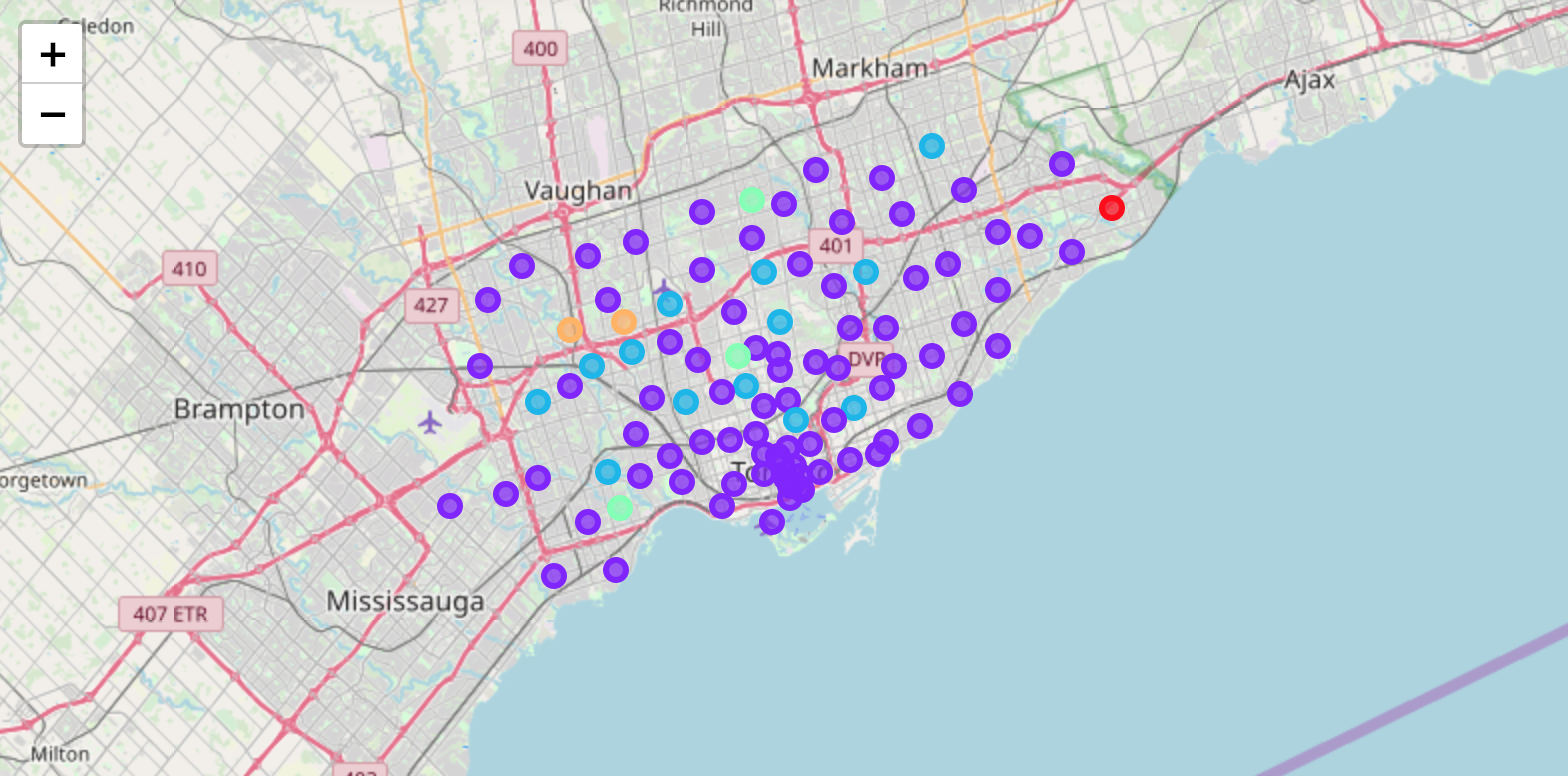